# ML4HC C. Elegans dataset


Team members: 


>First Name| Last Name | Student number
>--- | --- | --- | 
>Sotiris | Anagnostidis | 18-949-743
>Adamos | Solomou | 18-947-192
>Georgios | Vasilakopoulos | 18-954-768


The computation of the entire notebook requires a considerable amount of execution time, so we do not advice a throughout execution of it. Many cells contain cross-validation commands in order to select optimal hyperparameters for the models that were developed.

Prepare the notebook

### Purpose of the project

Given the C. Elegans DNA dataset, the purpose of this project is to predict splice site given the DNA sequence.  

In this Jupyter notebook we will attempt to classify these sequences using different methods. More specifically we will concetrate more on trying to correctly quantify simmilarities between gene sequences by defining appropriate similarity measures. 

The quality of our results will be measured by means of the following two scores: 


*   Area under the Receiver Operating Characteristic Curve (AUROC)
*   Area under the Precision Recall Curve (AUPRC)





## Import the dataset

In [0]:
import collections
import numpy as np
import pandas as pd
import shogun as sg

In [4]:
!if [ ! -f C_elegans_acc_seq.csv ]; then wget -nv http://svmcompbio.tuebingen.mpg.de/data/C_elegans_acc_seq.csv -O C_elegans_acc_seq.csv; fi

2019-03-20 18:29:20 URL:http://svmcompbio.tuebingen.mpg.de/data/C_elegans_acc_seq.csv [195600/195600] -> "C_elegans_acc_seq.csv" [1]


In [5]:
dataset = pd.read_csv('C_elegans_acc_seq.csv', header=None, names=['class', 'sequence'])
dataset.head(5)

,class,sequence
0,1.0,ACTGGGATAATTTGAAACAATAAATTTTTTTTTGAATTGTAGGTGT...
1,1.0,ATTGATTGAATATTAATTGTTATTTGACGTTATTTTTTAAAGAACT...
2,1.0,TTTAAACTTCGATTTTTTTCAAATAAAACATATTTTTTTCAGCCAG...
3,1.0,TAGCCAGATTTTTAGCAGGTTTTAGCAGAAAAACGTTTTCAGACGA...
4,1.0,TAAACCGCCGATTCTTAAAATTAATTTTTCTTTCTTTTTCAGATGA...


We explore how balanced the classes are within the dataset.

In [6]:
# make two classes being predicted 0 and 1 instead of -1 and 1
# this will be useful to easier calculate predicted probabilities

dataset['class'].values[dataset['class'].values == -1] = 0

for value, frequency in collections.Counter(dataset['class'].values).items():
    print('value: %2d found: %4d times' % (value, frequency))

value:  1 found:  200 times
value:  0 found: 2000 times


As specified during the presentation of the exercise, classes are heavily unbalanced. This will play a crucial role for the following reasons:


*   Most classifiers are trained without taking the number of samples per class into account. In order to alleviate this fact two main approaches can be inherited. First, we can either undersample over-represented class, which is not recommended in this case due to the small number of overall data points, or oversample the under-represented class by replicating some data points. Second, we can modify the loss function of the model by appropriately weighting point-wise errors so that a larger loss is incured when the model incorectly classifies a sample from the under-represented class. These weights will constitude a design parameter of the model. Due to the small size of the dataset, we decided to follow the second approch (weighted loss).

*   During the evaluation phase, metrics that do not take into account the relative frequency of classes, will be harder to interpret and might also lead to misleading results like the accuracy paradox. For example, the AUROC score does not take this fact into account.  



For the following parts we will split the data, keeping a test set for the final evaluation. We should mention that such a split increases the bias of the final results, as they will slightly depend on this split.


In [0]:
from sklearn.model_selection import train_test_split
 
features, features_test, labels, labels_test = train_test_split(dataset['sequence'].values, dataset['class'].values, test_size=0.2, random_state=17)

In the next sections we present how we experimented with different methods and the best results we achieved with each one.

## Support Vector Machine

We experimented using different kernels for the SVM trying to capture dependencies between DNA sequences.

The kernels presented during the lectures and the ones we experienced the most success with were the following:


*   CommWordStringKernel
*   WeightedDegreeStringKernel
*   WeightedDegreePositionStringKernel

Now we will present the function of each kernel and the reasons why we can expect them to provide promising results. 


### CommWordStringKernel

This kernel is used to compute the spectrum kernel from strings. Most precisely it computes:


$$k(x, x') = Φ_k(x) \times Φ_k(x') $$

where $Φ_k$ is a new vector representation of $x$. Effectively, $Φ_k$ maps the raw sequence $x$ that consits of letters in some vocabulary $V$ to a feature vector of size $|V|^k$ where $|V|$ denotes the cardinality of the vocabulary. In this transformed feature vector, each entry corresponds to the number of times that a specific $k-$mer was observed in the original sequence $x$.

The main disadvantage of this kernel is that exact positition that each $k-$mer was observed is discarded, preserving only information regarding the number of occurances of each $k-$mer (similar to the bag-of-words concept). This technique, makes use of position-independent motifs. 


### WeightedDegreeStringKernel

This kernel sums all contributions of $k-$mer matches of lengths $k \in \{1,...,d\}$ where $d$ is the maximal "match length" taken into account, also known as the kernel degree. Furthermore, the kernel weights each contribution by the corresponding weight $\beta_k$. The kernel is formulated as follows, 

$$k(x, x') = \sum_{k=1}^d \beta_k \sum_{l=1}^{L-k+1} I(u_{k,l}(x) = u_{k,l}(x'))$$

where $I$ is the indicator function and $u_{k,l}(x)$ denotes the string of length $k$ starting at position $l$ for the sequence $x$.

In contrast to the previous kernel, the Weighted Degree String kernel makes use of position-dependent motifs, taking into account the exact position of each $k-$mer. This is useful as one could expect similar patterns to apper close to splice sites. This will also become apparent from the results that are presented subsequently. 

### WeightedDegreePositionStringKernel

Building from the ideas of the previous case, we attempt to further expand on previous results by allowing sequences to not be completely aligned with each other [1].




![](https://drive.google.com/uc?export=view&id=1tBiYQAz38AcoypkfmDhivcUjmUo5LMfz)



In [0]:
from sklearn.utils import shuffle 
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split, KFold

from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, precision_recall_curve
from sklearn.metrics import roc_curve, auc, classification_report, make_scorer
from sklearn.model_selection import GridSearchCV

### Class custom SVM 
#### Αvailable kernels : 
##### "CommWordStringKernel", "WeightedDegreeStringKernel", "WeightedDegreePositionStringKernel"


In [0]:
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.svm import SVC
from shogun import WeightedDegreeStringKernel, CommWordStringKernel, WeightedDegreePositionStringKernel
from shogun import StringCharFeatures, StringWordFeatures
from shogun import SqrtDiagKernelNormalizer, IdentityKernelNormalizer
from shogun import DNA

class custom_SVM(BaseEstimator, ClassifierMixin):  
    """
    Implementation of SVM using different shogun kernels
    This implementation is elaborate and does not offer much flexibility mainly 
    due to the fact that every kernel implemented requires different features 
    from the original dna sequences. In order to provide a cleaner interface 
    we tranfered this overhead inside the svm class.
    """

    available_kernels = ["CommWordStringKernel", "WeightedDegreeStringKernel", "WeightedDegreePositionStringKernel"]
    
    def __init__(self, kernel="WeightedDegreePositionStringKernel", kernel_degree=5, C=1.0, class_weight=None, random_state=None,
                order=2, gap=0, reverse=False, use_sign=False, normalizer=None, shift=10, kernel_weights=None):
      
        if type(kernel) is list:
            assert all(k in self.available_kernels for k in kernel), "kernel selected not implemented"
        else:
            assert kernel in self.available_kernels, "kernel selected not implemented"
            
        assert (type(kernel) is not list or type(kernel_weights) is list and len(kernel) == len(kernel_weights)), "if list of kernels specified the kernel_weights should also be specified"
        
        self.kernel = kernel
        self.kernel_degree = kernel_degree
        self.order = order
        self.gap = gap
        self.reverse = reverse
        self.use_sign = use_sign
        self.shift = shift
        self.kernel_weights = kernel_weights
        
        self.normalizer = normalizer
        
        self.C = C
        self.random_state = random_state
        self.class_weight = class_weight
        self.clf = SVC(C=C, class_weight=class_weight, kernel='precomputed', probability=True, random_state=random_state)
        
    def get_kernel_matrix(self, X):
        if type(self.kernel) is not list:
            return self._get_kernel_matrix(X)
        else:
            # combination of kernels
            final_kernel = self._get_kernel_matrix(X, computed_kernel=self.kernel[0]) * self.kernel_weights[0]
            for i in range(1, len(self.kernel)):
                final_kernel = final_kernel + self._get_kernel_matrix(X, computed_kernel=self.kernel[i]) * self.kernel_weights[i]
            return final_kernel
        
    def _get_kernel_matrix(self, X, computed_kernel=None):
        """
        Get kernel matrix from a list of strings.
        if kernel != None multiple kernels have been chosen
        """
        X = list(X)
        if computed_kernel == None:
            computed_kernel = self.kernel
        
        
        if computed_kernel == "CommWordStringKernel":
            # represent the strings as char features
            char_feats = StringCharFeatures(DNA)
            char_feats.set_features(X)

            # create a string features instance which contains counts for every k-mer
            # the obtain method counts every possible k-mer of the specified length and save the results as a list
            # of numbers (one for each possible k-mer)
            word_feats = StringWordFeatures(DNA)
            word_feats.obtain_from_char(char_feats, self.order - 1, self.order, self.gap, self.reverse)

            try:
                # predict phase
                X_train = list(self.X_train)
                
                char_feats_train = StringCharFeatures(DNA)
                char_feats_train.set_features(X_train)

                # create a string features instance which contains counts for every k-mer
                # the obtain method counts every possible k-mer of the specified length and save the results as a list
                # of numbers (one for each possible k-mer)
                word_feats_train = StringWordFeatures(DNA)
                word_feats_train.obtain_from_char(char_feats_train, self.order - 1, self.order, self.gap, self.reverse)
                
                kernel = CommWordStringKernel(word_feats, word_feats_train)
            except AttributeError:
                # fit phase
                kernel = CommWordStringKernel(word_feats, word_feats)
        elif computed_kernel == "WeightedDegreeStringKernel":
            features = sg.StringCharFeatures(X, sg.DNA)
            try:
                # predict phase
                X_train = list(self.X_train)
                
                features_train = sg.StringCharFeatures(X_train, sg.DNA)
            
                kernel = sg.WeightedDegreeStringKernel(features, features_train, self.kernel_degree)
            except AttributeError:
                # fit phase
                kernel = sg.WeightedDegreeStringKernel(features, features, self.kernel_degree)
        elif computed_kernel == "WeightedDegreePositionStringKernel":
            features = StringCharFeatures(X, sg.DNA)
            try:
                # predict phase
                X_train = list(self.X_train)
                
                features_train = sg.StringCharFeatures(X_train, sg.DNA)
                
                kernel = sg.WeightedDegreePositionStringKernel(features, features_train, self.kernel_degree)
            except AttributeError:
                # fit phase
                kernel = sg.WeightedDegreePositionStringKernel(features, features, self.kernel_degree)
            
            kernel.set_shifts(self.shift * np.ones(len(X[0]), dtype=np.int32))
            kernel.set_position_weights(np.ones(len(X[0]), dtype=np.float64))    
        
    
        return kernel.get_kernel_matrix()
        
       
    def fit(self, X, y=None):
        """
        All necessary checks are made in the sklearn SVM used 
        """
        self.X_train = X
        self.clf.fit(self.get_kernel_matrix(X), y)
        self.treshold_ = 0.2
        return self

    def _meaning(self, x):
        # returns True/False according to fitted classifier
        return( True if x >= self.treshold_ else False )

    def predict(self, X):
        return (self.decision_function(X)[:, 1] > 0.5).astype(np.int16)
        
    def score(self, X, y, sample_weight=None):
        from sklearn.metrics import accuracy_score
        return accuracy_score(y, self.predict(X), sample_weight=sample_weight)
      
    def decision_function(self, X):
        return self.clf.predict_proba(self.get_kernel_matrix(X))
      
    def predict_proba(self, X):
        return self.decision_function(X)
      
    def get_params(self, deep = False):
        return {'kernel': self.kernel, 'C': self.C, 
                'kernel_degree': self.kernel_degree, 
                'random_state': self.random_state, 
                'class_weight': self.class_weight,
                'gap': self.gap, 'order': self.order,
                'shift': self.shift, 
                'kernel_weights': self.kernel_weights}

### Scoring Functions

In [0]:
def AUPRC(y_true, y_pred):
    precision, recall, thresholds_prc = precision_recall_curve(y_true, y_pred)
    # compute precision-recall curve
    return auc(recall, precision)

def print_scores(features_test, labels_test, scores, clf):
    """
    Takes as input a dictionary of scorers and outputs the score for each one
    """
    for scorer, score in scores.items():
        print('scorer: %10s score %f' % (scorer, score(clf, features_test, labels_test)))
      

scores = {'ROC_AUC': make_scorer(roc_auc_score, needs_proba=True), 
          'AUPRC': make_scorer(AUPRC, needs_proba=True)}

Next we complete a GridSearch to find the best parameters for our model. 

We experimented we the three kernels as described above. 

We should mention that we tried out a lot more parameters than the ones specified here, but these are presented for completeness reasons.

For this section as well for the ones to follow, all results are presented with a mean score value and a confidence interval of two times the standard deviation around the mean.

### Hyperparameter Selection 

In [0]:
# Set the parameters by cross-validation
tuned_parameters = [{'kernel': ['WeightedDegreeStringKernel'], 
                     'kernel_degree': [4, 5, 6, 7, 8, 9, 10], 'C': [0.001, 0.005, 0.01, 0.1, 1],
                     'class_weight': ['balanced', None]},
                    {'kernel': ['CommWordStringKernel'], 
                     'C': [0.01, 0.1, 1, 10], 'order': [2, 3, 4], 'gap': [0, 1, 2],
                     'class_weight': ['balanced', None]},
                   {'kernel': ['WeightedDegreePositionStringKernel'], 
                    'C': [0.001, 0.005, 0.01, 0.1, 1],
                    'class_weight': ['balanced', None],
                    'kernel_degree': [4, 5, 6, 7, 8], 'shift': [2, 5, 10, 20]}]

for scorer, score in scores.items():
    print('===================================================================')
    print("# Tuning hyper-parameters for %s" % scorer)
    print()

    clf = GridSearchCV(custom_SVM(), tuned_parameters, cv=5,
                       scoring=score)
    clf.fit(features, labels)

    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)
    print(clf.best_score_)
    print()
    print("Grid scores on development set:")
    print()
    
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))
    print()

    print("Detailed classification report:")
    print()
    print("The model is trained on the full development set.")
    print('Validation test score for %s and the best estimator ' % scorer)
    print()
    print(score(clf, features_test, labels_test))
    print()


Here are the best results we obtained for each kernel separately. We specified two different metrics for the evaluation of the results. Since not significant statistical differences were introduced between models that achieved the best results for the one metric compared to the other, we present a single model for each kernel for the two different kernels below. These results come from a 5-fold cross validation on the training set. 

---

>Kernel| kernel parameters | ROC_AUC score | AUPRC score
>--- | --- | --- | ---
>CommWordStringKernel | 'C': 0.1, 'class_weight': 'balanced', 'gap': 0, 'order': 2 | 0.832 (+/-0.036) | 0.441 (+/-0.177)
>WeightedDegreeStringKernel | 'C': 0.1, 'class_weight': 'balanced', 'kernel_degree': 5 | 0.987 (+/-0.009) | 0.893 (+/-0.123)
>WeightedDegreePositionStringKernel | 'C': 0.1, 'class_weight': 'balanced', 'kernel_degree': 5, 'shift': 18} | 0.991 (+/-0.009) | 0.911 (+/-0.139)

As expected the spectrum kernel fails to recognize dependencies between splite sites. We can also observe that the introduction of shifts increases the overall accuracy for the weighted degree kernel.

---

Based on well-known kernel properties, the weighted sum of two kernel functions is also a kernel function provided that the weighting coefficients are positive. 

$$k(x, x') = \alpha \times k_1(x, x') + \beta \times k_2(x, x') \space where \space \alpha > 0, \beta >0$$

We will use this result to combine the two kernels that gave rise to the highest scores. That is, the weighted degree string kernel and the weighted degree string kernel with shifts. A precise evaluation would require an exhaustive grid search over the combination of all parameters including weights $\alpha, \beta$. As results were similar and due to limited computational resources, we resort only to the best results from above. We should mention that both kernels model similar quantities. As a result we can expect that their output can be directly related and no particular weighting process should take place.

A different approach would result to training individual models and combining them at the end of their training phase. This will be exploited at a later section.

### Combination of different kernels

Here we combine the kernels that previously outputed the best results. 

In [0]:
from sklearn.model_selection import cross_val_score

for scorer, score in scores.items():
    print('===================================================================')
    print("# Tuning hyper-parameters for %s" % scorer)
    print()

    for i in np.arange(0, 0.75, 0.05):
      clf = custom_SVM(C=0.1, kernel_degree=5, shift=18, kernel=["WeightedDegreeStringKernel", "WeightedDegreePositionStringKernel"], class_weight='balanced', kernel_weights=[i, 1])
      cv_scores = cross_val_score(clf, features, labels, cv=5, scoring=score)
      print("%0.5f (+/-%0.03f) for weights [%0.2f, 1]" % (np.mean(cv_scores), np.std(cv_scores) * 2, i))      

The results above lead to the conclusion that the use of multiple kernel functions (as a linear combination) could improve slightly the quality of our predictions. Taking into account the standard deviation of the results, we could make the argument that these improvements are not statistically important. Nevertheless, for reasons of completeness reason they are presented here. 


In [0]:
# hard code results of the previous experiments for persistence after restarting the kernel

weights = np.arange(0, 0.75, 0.05)
relative_weights = weights / (weights + 1)
aur_roc_scores = [0.99126, 0.99138, 0.99142, 0.99142, 0.99138, 
                  0.99140, 0.99138, 0.99150, 0.99162, 0.99160, 
                  0.99168, 0.99166, 0.99146, 0.99144, 0.99144]
aur_roc_std = [0.009] * 12 + [0.01] * 3
auprc_scores = [0.91094, 0.91181, 0.91251, 0.91325, 0.91352, 
                0.91407, 0.91427, 0.91590, 0.91714, 0.91706,
                0.91775, 0.91801, 0.91642, 0.91628, 0.91646]
auprc_scores_std = [0.139, 0.140, 0.141, 0.139, 0.137, 
                    0.137, 0.137, 0.133, 0.134, 0.135,
                    0.133, 0.134, 0.136, 0.134, 0.132]

In [0]:
import matplotlib.pyplot as plt
import seaborn
from pylab import rcParams

%matplotlib inline

rcParams['figure.figsize'] = 15, 7

Best results by combining kernels.
All results are presented with a 2 standard deviation error bar around the mean.
Quantity relative weight refers to the relative weight of the kernel 'WeightedDegreeStringKernel' as opposed to 'WeightedDegreePositionStringKernel'.


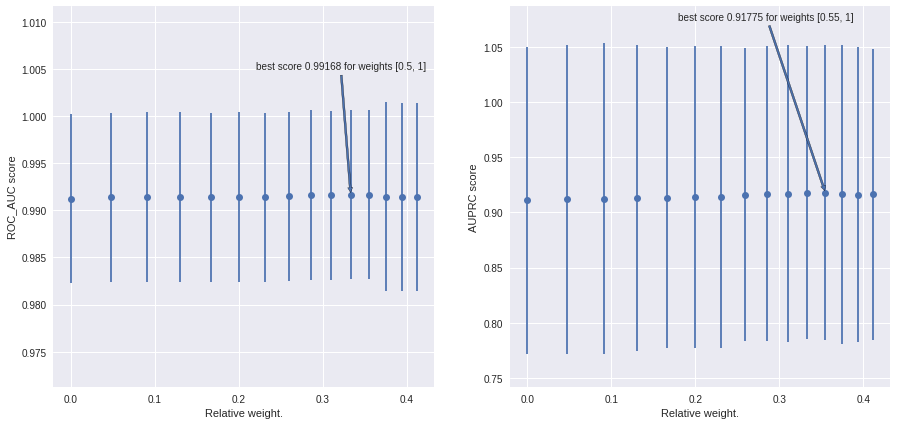

In [0]:
# Now switch to a more OO interface to exercise more features.
fig, axs = plt.subplots(nrows=1, ncols=2)

ax = axs[0]
ax.errorbar(relative_weights, aur_roc_scores, yerr=aur_roc_std, fmt='o')

best_i_index = 10
ax.annotate("best score 0.99168 for weights [0.5, 1]", xy=(relative_weights[best_i_index], aur_roc_scores[best_i_index]),
             xytext=(0.22, 1.005),
             arrowprops=dict(arrowstyle="simple"))
ax.set_ylim([np.min(aur_roc_scores) - np.max(aur_roc_std) * 2, np.max(aur_roc_scores) + np.max(aur_roc_std) * 2])

ax.set_ylabel('ROC_AUC score')
ax.set_xlabel('Relative weight.')



ax = axs[1]
ax.errorbar(relative_weights, auprc_scores, yerr=auprc_scores_std, fmt='o')

best_i_index = 11
ax.annotate("best score 0.91775 for weights [0.55, 1]", xy=(relative_weights[best_i_index], auprc_scores[best_i_index]),
             xytext=(0.18, 1.075),
             arrowprops=dict(arrowstyle="simple"))
ax.set_ylim([np.min(auprc_scores) - np.max(auprc_scores_std)*1.2, np.max(auprc_scores) + np.max(auprc_scores_std)*1.2])

ax.set_ylabel('AUPRC score')
ax.set_xlabel('Relative weight.')


print('Best results by combining kernels.\nAll results are presented with a 2 standard deviation error bar around the mean.')
print("Quantity relative weight refers to the relative weight of the kernel 'WeightedDegreeStringKernel' as opposed to 'WeightedDegreePositionStringKernel'.")
plt.show()

The best results for each score function were not achieved for the same weight between the kernels. However, differences are insignificant, especially for cases close to the weights 0.55, 0.6 that produced the best results. We continue with the best weight parameters of [0.5, 1] for the rest of this analysis.

A major challenge in this project is the task of finding a suitable feature representation of each DNA sequence that is capable to capture the most important characteristics relevent to splicing prediction. So far, we experimented using the SVM classifier in combination with a domain-specific string kernel. 
An alternative approach would be to retrieve the feature representation computed by the kernel function and feed these extracted features to a different classifier. We experimented heavili with this approach but did not manage to reach scores similar to the ones achieved when using the SVM classifier. The reason is that the kernels previously described attempted to create a feature representation in a high dimensional space managing to compare samples in that space. The SVM by taking the inner product achieves to resolve this similarity.

## Recurrent neural network

Following the trend in the last years, we briefly experimented with artificial neural networks where connections between nodes form a directed graph along a temporal sequence, recurrent neural networks. We can expect that temporal relationships between successive genes can be captured. To alleviate for dependencies between genes with a considerable distance between them, we use Long short-term memory (LSTM) units, that can capture better cases such as these.

In [13]:
from keras.models import Sequential
from keras.layers import Dropout
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Bidirectional
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from keras import metrics
from keras.callbacks import EarlyStopping

Using TensorFlow backend.


In [0]:
mapping = {'C': 0, 'T': 1, 'G': 2, 'A': 3}

def features_to_one_hot_encoding(features):
    features_to_numbers_mapping = np.array([[mapping[i] for i in list(x)] for x in features])
    
    features_one_hot_encoding = np.zeros((rnn_features_train.shape +  (len(mapping),)), dtype=int)
    for i, train_sample in enumerate(rnn_features_train):
        features_one_hot_encoding[i, np.arange(rnn_features_train[0].size), train_sample] = 1
        
    return features_one_hot_encoding
  
def features_to_number_list(features):
    return np.array([[mapping[i] for i in list(x)] for x in features])

In [0]:
import tensorflow as tf

def auc_roc(y_true, y_pred):
    # any tensorflow metric
    value, update_op = tf.contrib.metrics.streaming_auc(y_pred, y_true)

    # find all variables created for this metric
    metric_vars = [i for i in tf.local_variables() if 'auc_roc' in i.name.split('/')[1]]

    # Add metric variables to GLOBAL_VARIABLES collection.
    # They will be initialized for new session.
    for v in metric_vars:
        tf.add_to_collection(tf.GraphKeys.GLOBAL_VARIABLES, v)

    # force to update metric values
    with tf.control_dependencies([update_op]):
        value = tf.identity(value)
        return value

In [0]:
X_train = features_to_number_list(features)
X_test = features_to_number_list(features_test)

# create validation set 
X_train_train, X_train_test, labels_train_train, labels_train_test = train_test_split(
    X_train, labels, test_size=0.2, random_state=17)

Define the model parameters.

The embedding method was inspired from [2] to provide a better generalization.

In [0]:
def create_model(bidirectional=True):
    model = Sequential()
    model.add(Embedding(4, 4, input_length=len(X_train[0])))
    if bidirectional:
        model.add(Bidirectional(LSTM(40)))
    else:
        model.add(LSTM(40))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=[auc_roc])
    print(model.summary())
    return model
  
model = create_model(bidirectional=True)

In [0]:
my_callbacks = [EarlyStopping(monitor='auc_roc', patience=50, verbose=1, mode='max')]

number_of_classes_0 = collections.Counter(labels_train_train)[0]
number_of_classes_1 = len(labels_train_train) - number_of_classes_0

model.fit(X_train_train, labels_train_train, validation_data=(X_train_test, labels_train_test), epochs=1000, batch_size=128, 
          class_weight={0: number_of_classes_1 / len(labels_train_train), 1: number_of_classes_0 / len(labels_train_train)},
          callbacks=my_callbacks)

We now print the results for the based weights as monitored from the validation set. We should mention that the results provided here are somewhat different as for the calculation of the area under the curve the raw probabilities of the predictions can be taken into account.

In [0]:
# from google.colab import files

#model.save_weights('model_weights.h5')
#files.download('model_weights.h5') 

The best results we could achieve with this method is AUR_ROC = 0.9731 and AUPRC = 0.8920 for the test set.
We should mention that our knowledge in RNNs is limited and potential much better results could be achieved. We experimented combining the predictions of these classifiers by creating a weighted voting between them, but no better results occurred. 

## Final predictions

Here we present the best classifier we could train. We train on the whole dataset. This may introduce some bias as the hyperparameters were selected from performing cross validation on the training set. We expect this fact not to affect our results. 

In [29]:
clf = custom_SVM(C=0.1, kernel_degree=5, shift=18, kernel=["WeightedDegreeStringKernel", "WeightedDegreePositionStringKernel"], class_weight='balanced', kernel_weights=[0.5, 1])
clf.fit(features, labels)

custom_SVM(C=0.1, class_weight='balanced', gap=0,
      kernel=['WeightedDegreeStringKernel', 'WeightedDegreePositionStringKernel'],
      kernel_degree=5, kernel_weights=[0.5, 1], order=2, random_state=None,
      shift=18)

In [0]:
# classes are 0 and 1

predictions = clf.predict(features_test)
predictions_proba = clf.predict_proba(features_test)[:, 1]

## Visualizations

In [0]:
def plot_roc_curve(true_values, predicted_values):
    # compute ROC curve
    fpr, tpr, thresholds_roc = roc_curve(true_values, predicted_values)
    roc_auc = auc(fpr, tpr)
    precision, recall, thresholds_prc = precision_recall_curve(true_values, predicted_values)

    # compute precision-recall curve
    auprc = auc(recall, precision)
    precision_random, recall_random, thresholds_random = precision_recall_curve(true_values, np.random.rand(len(true_values)))
    auprc_random = auc(recall_random, precision_random)
    other_scores_validation = [roc_auc, auprc, auprc_random]

    # plot curves
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
                     lw=lw, label='ROC curve (area = %0.4f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('1 - Specificity / False Positive Rate')
    plt.ylabel('Sensibility / True Positive Rate')
    plt.title('Receiver Operating Characteristic curve')
    plt.legend(loc="lower right")
    #plt.savefig('./models/' + experiment_id + '/' + model_name + '_roc_curve_validation.png')

    plt.figure()
    lw = 2
    plt.plot(recall, precision, color='darkorange',
                         lw=lw, label='AUPRC curve (area = %0.4f)' % auprc)
    plt.plot(recall_random, precision_random, color='navy', linestyle='--',
                         lw=lw, label='random AUPRC curve (area = %0.4f)' % auprc_random)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall curve')
    plt.legend(loc="best")

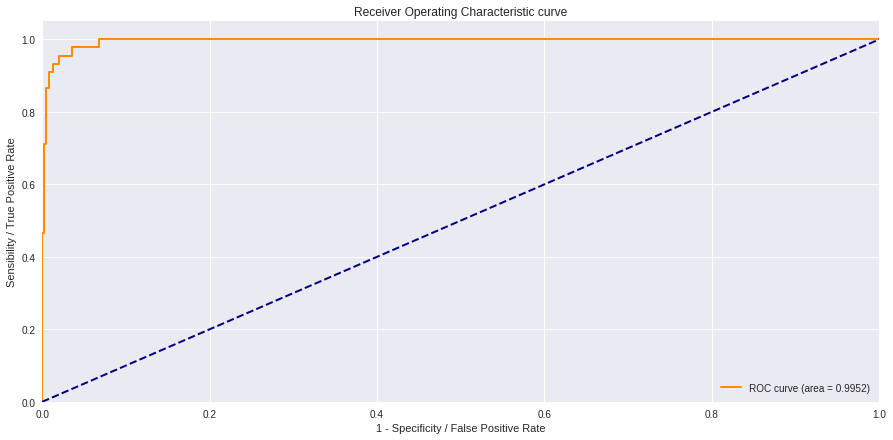

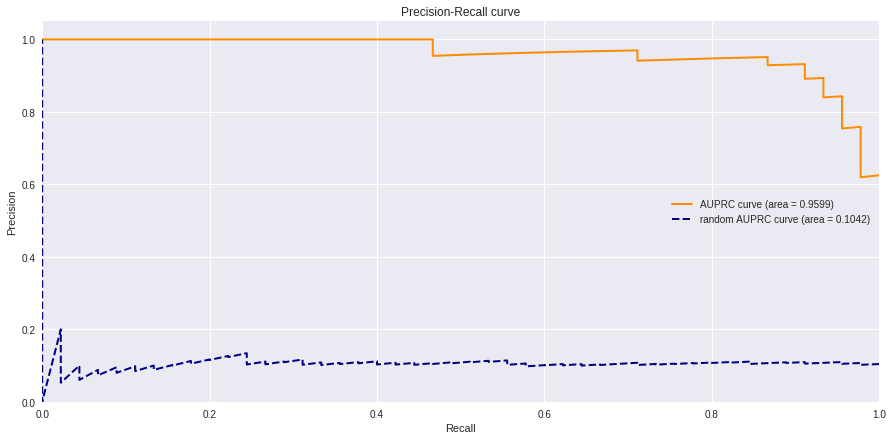

In [32]:
plot_roc_curve(labels_test, predictions_proba)

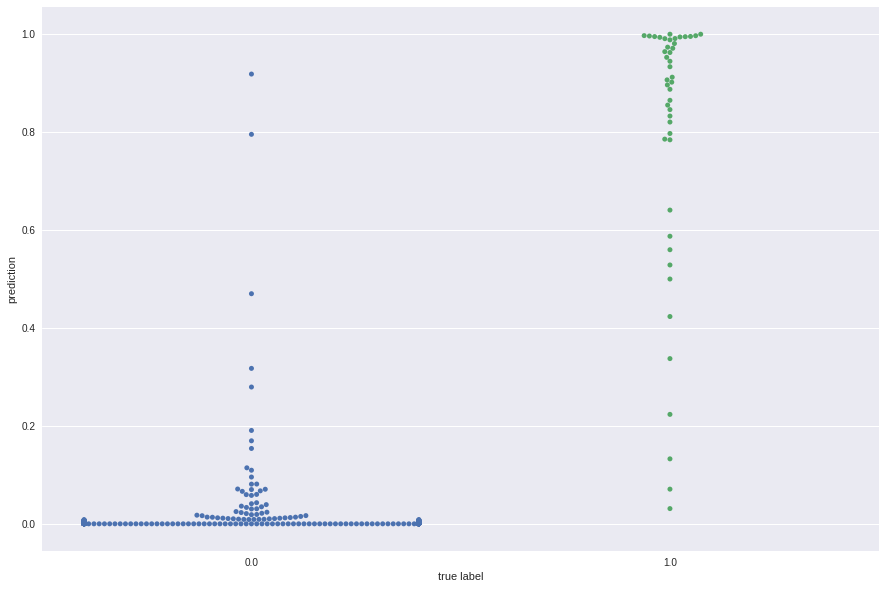

In [33]:
df = pd.DataFrame()
df['prediction'] = predictions_proba
df['true label'] = labels_test

seaborn.set(rc={'figure.figsize': (15, 10)})
seaborn.swarmplot(y='prediction', x='true label', data=df)

As we can observe our best method managed to achieve a AUC_ROC score of 0.9952 and a AUPRC score of 0.9599. This score of course depends also on the the random split to create this test set.


## Discussion

In this notebook we experimented with some of the methods known to give the most promising results. We tried different algorithms and parameters. We found the most success using Support Vector Machines with established kernels and combinations of them. In the next notebook, we will adapt some of the methods proposed here to human DNA for the same classification task.


Here for completeness reasons we provide some of the final results in the form requested in a pandas dataframe format. These include some of the best configurations after searching through the parameter space by conducting cross validation. All results regard the test set, created at the beginning.

We can observe that for this specific split, our selected model performs marginally worse than other candidate models. Nonetheless, we base our selection on the cross-validation performance of each model rather than the test score. Τhe above scores indicate the performance of each model on a particular (random) test set and it may happen that for different train-test splits our model outperforms the alternative candidate models. We can expect that these biases will be eliminated for an infinite size of the train set, used for the model selection and of course the finite size of the test set (only 440 samples).

In [28]:
# WeightedDegreeStringKernel best configurations: C:0.1 class_weight: balanced kernel_degree: 5
# WeightedDegreePositionStringKernel best configurations: C:0.1 class_weight: balanced kernel_degree: 5 shift: 18

models = [['Bidirectional LSTMs', 0.9731, 0.8920],
          ['WeightedDegreeStringKernel', 0.9915, 0.9294],
          ['WeightedDegreePositionStringKernel', 0.9956, 0.9682],
          ['Weighted average of previous two kernels', 0.9952, 0.9559]]


classifiers = pd.DataFrame(models, columns=['model name', 'AUROC', 'AUPRC'])
classifiers

,model name,AUROC,AUPRC
0,Bidirectional LSTMs,0.9731,0.8920
1,WeightedDegreeStringKernel,0.9915,0.9294
2,WeightedDegreePositionStringKernel,0.9956,0.9682
3,Weighted average of previous two kernels,0.9952,0.9559


## References



*  [1] G. Ratsch, S. Sonnenburg, and B. Scholkopf. RASE: recognition of
alternatively spliced exons in C. elegans. Bioinformatics, 21(Suppl. 1):
i369–i377, June 2005.

*  [2] B. Lee, T. Lee, B. Na, and S. Yoon. DNA-level splice junction
prediction using deep recurrent neural networks. arXiv
preprint arXiv:1512.05135, 2015.




<!--bibtex

@Article{PER-GRA:2007,
  Author    = {P\'erez, Fernando and Granger, Brian E.},
  Title     = {{IP}ython: a System for Interactive Scientific Computing},
  Journal   = {Computing in Science and Engineering},
  Volume    = {9},
  Number    = {3},
  Pages     = {21--29},
  month     = may,
  year      = 2007,
  url       = "http://ipython.org",
  ISSN      = "1521-9615",
  doi       = {10.1109/MCSE.2007.53},
  publisher = {IEEE Computer Society},
}

@article{Papa2007,
  author = {Papa, David A. and Markov, Igor L.},
  journal = {Approximation algorithms and metaheuristics},
  pages = {1--38},
  title = {{Hypergraph partitioning and clustering}},
  url = {http://www.podload.org/pubs/book/part\_survey.pdf},
  year = {2007}
}

-->

<!--bibtex

@Article{PER-GRA:2007,
  Author    = {P\'erez, Fernando and Granger, Brian E.},
  Title     = {{IP}ython: a System for Interactive Scientific Computing},
  Journal   = {Computing in Science and Engineering},
  Volume    = {9},
  Number    = {3},
  Pages     = {21--29},
  month     = may,
  year      = 2007,
  url       = "http://ipython.org",
  ISSN      = "1521-9615",
  doi       = {10.1109/MCSE.2007.53},
  publisher = {IEEE Computer Society},
}

@article{Papa2007,
  author = {Papa, David A. and Markov, Igor L.},
  journal = {Approximation algorithms and metaheuristics},
  pages = {1--38},
  title = {{Hypergraph partitioning and clustering}},
  url = {http://www.podload.org/pubs/book/part\_survey.pdf},
  year = {2007}
}

-->